# Image Classification - The Multi-class Weather Dataset

**Submission deadline: Friday 5 April, 11:55pm**

**Assessment weight: 15% of the total unit assessment.**

**Versions**

- Wednesday 13 March: Initial release

*Unless a Special Consideration request has been submitted and approved, a 5% penalty (of the total possible mark of the task) will be applied for each day a written report or presentation assessment is not submitted, up until the 7th day (including weekends). After the 7th day, a grade of ‘0’ will be awarded even if the assessment is submitted. The submission time for all uploaded assessments is **11:55 pm**. A 1-hour grace period will be provided to students who experience a technical concern. For any late submission of time-sensitive tasks, such as scheduled tests/exams, performance assessments/presentations, and/or scheduled practical assessments/labs, please apply for [Special Consideration](https://students.mq.edu.au/study/assessment-exams/special-consideration).*

In this assignment you will complete tasks for an end-to-end image classification application. We will train and test the data using the Multi-class Weather Dataset (MWD):

- https://data.mendeley.com/datasets/4drtyfjtfy/1

The MWD contains labelled images representing various weather scenarios. It is a small and popular dataset for practice with image classification.

# Connect to GitHub Classroom

Please follow these steps to connect:

1. Follow this invitation link and accept the invitation: https://classroom.github.com/a/TGh1XJFW
2. The link may ask you to sign in to GitHub (if you haven't signed in earlier). If you don't have a GitHub account, you will need to register.
3. Once you have logged in with GitHub, you may need to select your email address to associate your GitHub account with your email address (if you haven't done it in a previous COMP3420 activity). If you can't find your email address, please skip this step and contact diego.molla-aliod@mq.edu.au so that he can do the association manually.
4. Wait a minute or two, and refresh the browser until it indicates that your assignment repository has been created. Your repository is private to you, and you have administration privileges. Only you and the lecture will have access to it. The repository will be listed under the list of repositories belonging to this offering of COMP3420: https://github.com/orgs/COMP3420-2024S1/repositories
5. In contrast with assignment 1 and the practical sessions, your assignment repository will be empty and will not include starter code. you need to add this Jupyter notebook and commit the changes.

Please use the github repository linked to this GitHub classroom. Make sure that you continuously push commits and you provide useful commit comments. Note the following:

*  **1 mark of the assessment of this assignment is related to good practice with the use of GitHub.**
*  **We will also use github as a tool to check for possible plagiarism or contract cheating. For example, if someone only makes commits on the last day, we may investigate whether there was plagiarism or contract cheating.**


# Tasks
## Task 1 - Data exploration, preparation, and partition (4 marks)

Download the MWD from this site and unzip it:

- https://data.mendeley.com/datasets/4drtyfjtfy/1

You will observe that the zipped file contains 1,125 images representing various weather conditions. To facilitate the assessment of this assignment, please make sure that the images are in a folder named `dataset2` and this folder is in the same place as this jupyter notebook.

### 1.1 - data partition (2 marks)

Generate three CSV files named `my_training.csv`, `my_validation.csv`, and `my_test.csv` that partition the dataset into the training, validation, and test set. Each CSV file contains the following two fields:

- File path
- Image label

For example, the file `my_training.csv` could start like this:

```csv
dataset2/cloudy1.jpg,cloudy
dataset2/shine170.jpg,shine
dataset2/shine116.jpg,shine
```

Make sure that the partitions are created randomly, so that the label distribution is similar in each partition. Also, make sure that the samples are sorted in no particular order (randomly)

Display the label distribution of each partition, and display the first 10 rows of each partition.

The following sample files are available together with these instructions. Your files should look similar to these.

- `training.csv`
- `validation.csv`
- `test.csv`

**For the subsequent tasks in this assignment, use the files we provide (`training.csv`, `validation.csv`, `test.csv`). Do not use the files that you have generated, so that any errors generated by your solution do not carry to the rest of the assignment. Also, the files we provide conveniently removed references to images that have a number of channels different from 3.**




In [56]:
import os
import csv
import random
import re
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
from tensorflow.keras.layers import Flatten, Dense, Dropout
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [21]:
path = '/home/abinand-balajee/Documents/Artificial Intelligence for Text and Vision - COMP6420/assignment-2-Abinand0302/dataset2'

In [22]:
imagelist = [file for file in os.listdir(path)]

In [23]:
random.shuffle(imagelist)

In [24]:
totalsz = len(imagelist)
trainsz = int(0.6*totalsz)
valsz = int(0.2*totalsz)
testsz = totalsz - trainsz - valsz

In [25]:
train_set = imagelist[:trainsz]
val_set = imagelist[trainsz:trainsz + valsz]
test_set = imagelist[trainsz+valsz:]

In [26]:
def write_csv(filename, data):
    with open(filename, 'w', newline = '') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['File Path', 'Image Label'])
        for row in data:
            file_path = os.path.join(path, row)
            base = os.path.splitext(row)[0]
            label = ''.join([i for i in base if not i.isdigit()])  
            writer.writerow([file_path, label])

In [27]:
write_csv('training.csv', train_set)
write_csv('validation.csv', val_set)
write_csv('test.csv', test_set)

In [30]:
tr = pd.read_csv('training.csv')
val = pd.read_csv('test.csv')
te = pd.read_csv('validation.csv')

In [31]:
combined_labels = pd.concat([tr['Image Label'], val['Image Label'],te['Image Label']])

In [32]:
tr.head(10)

,File Path,Image Label
0,/home/abinand-balajee/Documents/Artificial Int...,shine
1,/home/abinand-balajee/Documents/Artificial Int...,shine
2,/home/abinand-balajee/Documents/Artificial Int...,cloudy
3,/home/abinand-balajee/Documents/Artificial Int...,sunrise
4,/home/abinand-balajee/Documents/Artificial Int...,cloudy
5,/home/abinand-balajee/Documents/Artificial Int...,shine
6,/home/abinand-balajee/Documents/Artificial Int...,rain
7,/home/abinand-balajee/Documents/Artificial Int...,shine
8,/home/abinand-balajee/Documents/Artificial Int...,shine
9,/home/abinand-balajee/Documents/Artificial Int...,sunrise


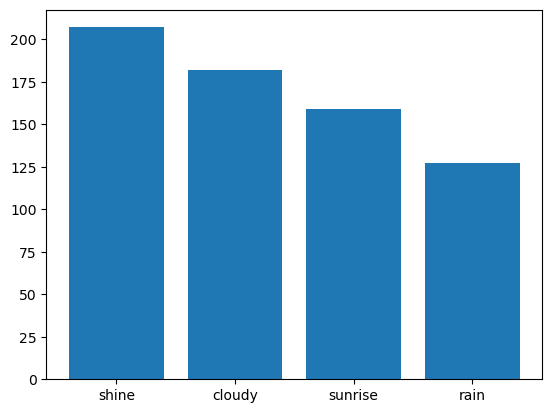

In [33]:
plt.bar(combined_labels.unique(), tr['Image Label'].value_counts())
plt.show()

In [34]:
val.head(10)

,File Path,Image Label
0,/home/abinand-balajee/Documents/Artificial Int...,sunrise
1,/home/abinand-balajee/Documents/Artificial Int...,cloudy
2,/home/abinand-balajee/Documents/Artificial Int...,shine
3,/home/abinand-balajee/Documents/Artificial Int...,rain
4,/home/abinand-balajee/Documents/Artificial Int...,rain
5,/home/abinand-balajee/Documents/Artificial Int...,cloudy
6,/home/abinand-balajee/Documents/Artificial Int...,sunrise
7,/home/abinand-balajee/Documents/Artificial Int...,sunrise
8,/home/abinand-balajee/Documents/Artificial Int...,sunrise
9,/home/abinand-balajee/Documents/Artificial Int...,sunrise


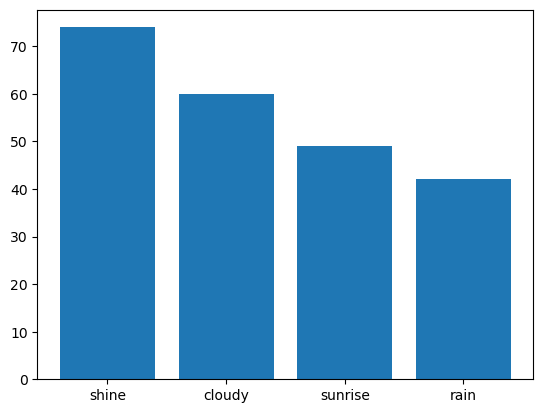

In [35]:
plt.bar(combined_labels.unique(), val['Image Label'].value_counts())
plt.show()

In [36]:
te.head(10)

,File Path,Image Label
0,/home/abinand-balajee/Documents/Artificial Int...,rain
1,/home/abinand-balajee/Documents/Artificial Int...,sunrise
2,/home/abinand-balajee/Documents/Artificial Int...,sunrise
3,/home/abinand-balajee/Documents/Artificial Int...,sunrise
4,/home/abinand-balajee/Documents/Artificial Int...,sunrise
5,/home/abinand-balajee/Documents/Artificial Int...,sunrise
6,/home/abinand-balajee/Documents/Artificial Int...,sunrise
7,/home/abinand-balajee/Documents/Artificial Int...,sunrise
8,/home/abinand-balajee/Documents/Artificial Int...,cloudy
9,/home/abinand-balajee/Documents/Artificial Int...,shine


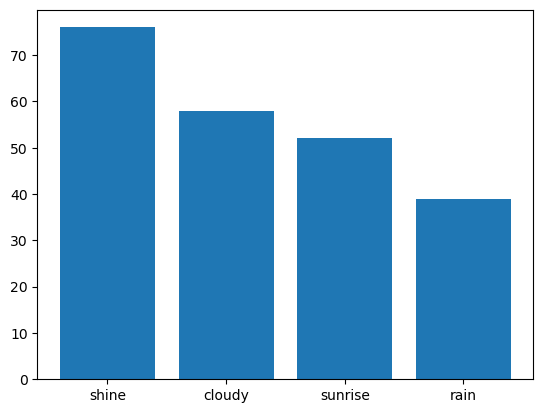

In [37]:
plt.bar(combined_labels.unique(), te['Image Label'].value_counts())
plt.show()

### 1.2 - preprocessing and preparation (2 marks)

Use TensorFlow's `TextLineDataset` to generate datasets for training, validation, and test. The datasets need to produce images that are re-sized to dimensions 230 x 230 and 3 channels, and the values of the pixels must be normalised to the range [0, 1].


In [38]:
Height = 230
Width = 230
Channels = 3
Class_names = ["cloudy", "rain", "shine", "sunrise"]
def read_and_decode(filename, reshape_dims):
    # Read the file
    img = tf.io.read_file(filename)
    
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_image(img, channels=Channels, expand_animations=False)
    
    # Use `convert_image_dtype` to convert to floats in the [0,1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    # Resize the image to the desired size
    return tf.image.resize(img, reshape_dims)
# decode_csv changed so that the label is the index into CLASS_NAMES array
def decode_csv(csv_row):
  record_defaults = ["path", "weather"]
  filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
  img = read_and_decode(filename, [Height, Width])
  label = tf.math.equal(Class_names, label_string) # to use with categorical crossentropy loss
  #label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string)) # to use with sparse categorical crossentropy loss
  return img, label

train_dataset = (tf.data.TextLineDataset(
    "training_given.csv").
    map(decode_csv)).batch(10)
val_dataset = (tf.data.TextLineDataset(
    "validation_given.csv").
    map(decode_csv)).batch(10)
test_dataset = (tf.data.TextLineDataset(
    "test_given.csv").
    map(decode_csv)).batch(10)

## Task 2 - A simple classifier (4 marks)

### 2.1 First classifier (1 mark)

Create a simple model that contains the following layers:

- A `Flatten` layer.
- The output layer with the correct size and activation function for this classification task.

Then, train the model with the training data. Use the validation data to determine when to stop training. Finally, test the trained model on the test data and report the accuracy.

In [61]:
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(Flatten(input_shape=(Height, Width, Channels)))
    
    units = hp.Int('units', min_value=32, max_value=512, step=32, default=128)
   
    model.add(layers.Dense(len(Class_names), activation='softmax'))

    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log', default=1e-3)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=2,
    directory='tuner_results',
    project_name='simple_classifier')

tuner.search(train_dataset,
             validation_data=val_dataset,
             epochs=10)

best_model_1 = tuner.get_best_models(num_models=1)[0]

Reloading Tuner from tuner_results/simple_classifier/tuner0.json


In [40]:
best_model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 158700)            0         
                                                                 
 dense (Dense)               (None, 4)                 634804    
                                                                 
Total params: 634,804
Trainable params: 634,804
Non-trainable params: 0
_________________________________________________________________


In [41]:
test_loss, test_accuracy = best_model_1.evaluate(test_dataset)

print("Test accuracy:", test_accuracy)

2024-04-04 02:38:15.331258: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


17/17 [==============================] - 1s 20ms/step - loss: 37.7905 - accuracy: 0.8047
Test accuracy: 0.8047337532043457


In [62]:
import numpy as np

predictions = best_model_1.predict(test_dataset)

predicted_labels = np.argmax(predictions, axis=1)

true_labels = np.concatenate([y for x, y in test_dataset], axis=0)
true_labels = np.argmax(true_labels, axis=1)

class_accuracies = {}
for i in range(len(Class_names)):
    class_indices = np.where(true_labels == i)[0]
    class_accuracy = np.mean(predicted_labels[class_indices] == true_labels[class_indices])
    class_accuracies[Class_names[i]] = class_accuracy

# Print accuracy for each class
for class_name, accuracy in class_accuracies.items():
    print(f"Accuracy for class {class_name}: {accuracy:.2f}")

17/17 [==============================] - 0s 22ms/step
Accuracy for class cloudy: 0.86
Accuracy for class rain: 0.59
Accuracy for class shine: 0.77
Accuracy for class sunrise: 0.92


### 2.2 A more complex classifier (2 marks)

Try a more complex architecture that has 1 or more hidden layers with dropout. For this more complex architecture, use `keras-tuner` and run it with a reasonable choice of possible parameters. You may try among the following:

- Number of hidden layers
- Sizes of hidden layers
- Dropout rate
- Learning rate

In [43]:
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(Flatten(input_shape=(Height, Width, Channels)))

    num_hidden_layers = hp.Int('num_hidden_layers', min_value=1, max_value=3, default=2)

    for i in range(num_hidden_layers):
        units = hp.Int(f'units_{i}', min_value=32, max_value=512, step=32, default=128)
        model.add(layers.Dense(units=units, activation='relu'))
        dropout_rate = hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, default=0.2)
        model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense(len(Class_names), activation='softmax'))

    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log', default=1e-3)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=2,
    directory='tuner_results',
    project_name='complex_classifier')

tuner.search(train_dataset,
             validation_data=val_dataset,
             epochs=10)

best_model_2 = tuner.get_best_models(num_models=1)[0]
best_model_2.summary()

Reloading Tuner from tuner_results/complex_classifier/tuner0.json
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 158700)            0         
                                                                 
 dense (Dense)               (None, 256)               40627456  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 40,628,484
Trainable params: 40,628,484
Non-trainable params: 0
_________________________________________________________________


In [44]:
best_hyperparameters = tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values

print("Best hyperparameters:")
for param, value in best_hyperparameters.items():
    print(f"{param}: {value}")

Best hyperparameters:
num_hidden_layers: 1
units_0: 256
dropout_0: 0.051837272096657616
units_1: 256
dropout_1: 0.36277478704679
learning_rate: 0.000212916243290288
units_2: 160
dropout_2: 0.12523988619665088


In [47]:
test_loss, test_accuracy = best_model_2.evaluate(test_dataset)

print("Test accuracy:", test_accuracy)

17/17 [==============================] - 1s 36ms/step - loss: 0.5246 - accuracy: 0.8521
Test accuracy: 0.8520709872245789


In [63]:
predictions = best_model_2.predict(test_dataset)

predicted_labels = np.argmax(predictions, axis=1)

true_labels = np.concatenate([y for x, y in test_dataset], axis=0)
true_labels = np.argmax(true_labels, axis=1)

class_accuracies = {}
for i in range(len(Class_names)):
    class_indices = np.where(true_labels == i)[0]
    class_accuracy = np.mean(predicted_labels[class_indices] == true_labels[class_indices])
    class_accuracies[Class_names[i]] = class_accuracy

for class_name, accuracy in class_accuracies.items():
    print(f"Accuracy for class {class_name}: {accuracy:.2f}")

17/17 [==============================] - 1s 35ms/step
Accuracy for class cloudy: 0.78
Accuracy for class rain: 0.88
Accuracy for class shine: 0.86
Accuracy for class sunrise: 0.96


I had run a Hyperparameter tuner to choose the best model. The validation set was used for this process. The hyperparameters The tuner looked for are learning rate, units(number of units in a layer), Number of hidden layers and droupout rate. The optimal hyperparameters according to the tuner are :
- num_hidden_layers: 1
- units(number of neurons): 256
- dropout rate : 0.051837272096657616
- learning rate : 0.000212916243290288


### 2.3 Error analysis (1 mark)

Evaluate your best-performing system from task 2 against the system of task 1 and answer the following questions.

1. Which system had a better accuracy on the test data?
2. Which system had a lower degree of overfitting?

The complex classifier with 1 hidden layer gave the best accuracty on the test data which was 0.85 compared to the simple classifier which gave an accuracy score of 0.80

In [49]:
global_seed = 42
tf.random.set_seed(global_seed)
np.random.seed(global_seed)

Epoch 1/10
79/79 [==============================] - 4s 51ms/step - loss: 71.0702 - accuracy: 0.7708 - val_loss: 99.5070 - val_accuracy: 0.7126
Epoch 2/10
79/79 [==============================] - 4s 47ms/step - loss: 103.4049 - accuracy: 0.7439 - val_loss: 85.5124 - val_accuracy: 0.7904
Epoch 3/10
79/79 [==============================] - 4s 49ms/step - loss: 61.8697 - accuracy: 0.8195 - val_loss: 105.4995 - val_accuracy: 0.6946
Epoch 4/10
79/79 [==============================] - 4s 50ms/step - loss: 46.8977 - accuracy: 0.8335 - val_loss: 120.2170 - val_accuracy: 0.7006
Epoch 5/10
79/79 [==============================] - 4s 49ms/step - loss: 56.3878 - accuracy: 0.8246 - val_loss: 71.3137 - val_accuracy: 0.7844
Epoch 6/10
79/79 [==============================] - 4s 50ms/step - loss: 48.0785 - accuracy: 0.8387 - val_loss: 115.9357 - val_accuracy: 0.6707
Epoch 7/10
79/79 [==============================] - 4s 49ms/step - loss: 33.6166 - accuracy: 0.8643 - val_loss: 71.8594 - val_accuracy: 0.

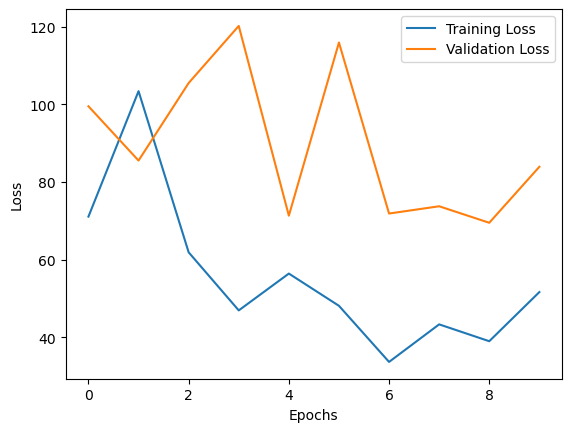

In [57]:
history = best_model_1.fit(train_dataset, epochs=10, validation_data=val_dataset)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch 1/10
79/79 [==============================] - 31s 389ms/step - loss: 0.4250 - accuracy: 0.8195 - val_loss: 0.6214 - val_accuracy: 0.7904
Epoch 2/10
79/79 [==============================] - 31s 386ms/step - loss: 0.4038 - accuracy: 0.8451 - val_loss: 0.7163 - val_accuracy: 0.7485
Epoch 3/10
79/79 [==============================] - 30s 383ms/step - loss: 0.4869 - accuracy: 0.7951 - val_loss: 0.6967 - val_accuracy: 0.7844
Epoch 4/10
79/79 [==============================] - 30s 385ms/step - loss: 0.4070 - accuracy: 0.8387 - val_loss: 0.7351 - val_accuracy: 0.7725
Epoch 5/10
79/79 [==============================] - 31s 386ms/step - loss: 0.4037 - accuracy: 0.8143 - val_loss: 0.6858 - val_accuracy: 0.7784
Epoch 6/10
79/79 [==============================] - 31s 388ms/step - loss: 0.3996 - accuracy: 0.8489 - val_loss: 0.7732 - val_accuracy: 0.7545
Epoch 7/10
79/79 [==============================] - 31s 386ms/step - loss: 0.3623 - accuracy: 0.8630 - val_loss: 0.7451 - val_accuracy: 0.7725

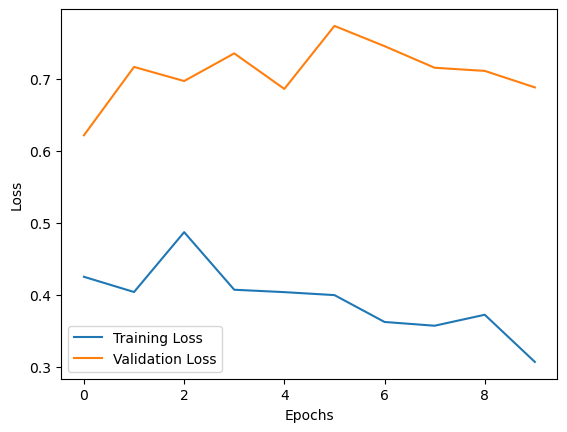

In [58]:
import matplotlib.pyplot as plt

history = best_model_2.fit(train_dataset, epochs=10, validation_data=val_dataset)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The complex classifier model had a lower degree of overfitting as the training loss decreased along with the validation loss while the validation loss in the simple classifier model increased while the training loss decreased.

## Task 3 - A more complex classifier (5 marks)

### Task 3.1 Using ConvNets (2 marks)

Implement a model that uses a sequence of at least two `ConvD`, each one followed with `MaxPooling2D`. Use reasonable numbers for the hyperparameters (number of filters, kernel size, pool size, activation, etc), base on what we have seen in the lectures. Feel free to research the internet and / or generative AI to help you find a reasonable choice of hyperparameters. For this task, do not use pre-trained models.

In [53]:
conv_model = tf.keras.Sequential([
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(Height, Width, Channels)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Flatten(),
    
    layers.Dense(128, activation='relu'),
    layers.Dense(len(Class_names), activation='softmax')
])

conv_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

conv_model.summary()
history = conv_model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 230, 230, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 115, 115, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 115, 115, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 57, 57, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 207936)            0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [54]:
test_loss, test_accuracy = conv_model.evaluate(test_dataset)
print("Test Accuracy:", test_accuracy)

17/17 [==============================] - 2s 91ms/step - loss: 0.2998 - accuracy: 0.8817
Test Accuracy: 0.88165682554245


In [55]:
predictions = conv_model.predict(test_dataset)

predicted_labels = np.argmax(predictions, axis=1)

true_labels = np.concatenate([y for x, y in test_dataset], axis=0)
true_labels = np.argmax(true_labels, axis=1)

class_accuracies = {}
for i in range(len(Class_names)):
    class_indices = np.where(true_labels == i)[0]
    class_accuracy = np.mean(predicted_labels[class_indices] == true_labels[class_indices])
    class_accuracies[Class_names[i]] = class_accuracy

for class_name, accuracy in class_accuracies.items():
    print(f"Accuracy for class {class_name}: {accuracy:.2f}")

17/17 [==============================] - 1s 74ms/step
Accuracy for class cloudy: 0.67
Accuracy for class rain: 0.91
Accuracy for class shine: 1.00
Accuracy for class sunrise: 1.00


### Task 3.2 Using pre-trained models (2 marks)

Use MobileNet, pre-trained on imagenet as discussed in the lectures. Add the correct classification layer, and train it with your data. Make sure that you freeze MobileNet's weights during training. Also, make sure you use a reasonable schedule for the learning rate.

In [59]:
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(Height, Width, Channels))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)  
x = Dense(128, activation='relu')(x)  
predictions = Dense(len(Class_names), activation='softmax')(x)  

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

history = model.fit(train_dataset, epochs=10, validation_data=val_dataset)

test_loss, test_accuracy = model.evaluate(test_dataset)
print("Test Accuracy:", test_accuracy)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 230, 230, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 115, 115, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 115, 115, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 115, 115, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 115, 115, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 115, 115, 32)     128       
 ation)                                                      

In [60]:
predictions = model.predict(test_dataset)

predicted_labels = np.argmax(predictions, axis=1)

true_labels = np.concatenate([y for x, y in test_dataset], axis=0)
true_labels = np.argmax(true_labels, axis=1)

class_accuracies = {}
for i in range(len(Class_names)):
    class_indices = np.where(true_labels == i)[0]
    class_accuracy = np.mean(predicted_labels[class_indices] == true_labels[class_indices])
    class_accuracies[Class_names[i]] = class_accuracy

for class_name, accuracy in class_accuracies.items():
    print(f"Accuracy for class {class_name}: {accuracy:.2f}")

17/17 [==============================] - 4s 186ms/step
Accuracy for class cloudy: 0.98
Accuracy for class rain: 1.00
Accuracy for class shine: 0.86
Accuracy for class sunrise: 0.98


### Task 3.3 Comparative evaluation (1 mark)

Compare the evaluation results of the best systems from tasks 3.1 and 3.2 and answer the following questions.

1. What system (including the systems you developed in Task 2) perform best on the test set?
2. Report the accuracy of your best system on each of the different weather categories. What type of weather was most difficult to detect?

The pre trained model (Mobilenet) offered the best accuracy when evaluated on the test dataset. 
- Pretrained model (Mobilenet) accuracy = 0.96
- Model Using Convulutional Neural Networks accuracy = 0.86
- Complex model with hidden layers accuracy = 0.85
- Simple Model with only an input layer(Flatten) and an Output layer accuracy = 0.80

The accuracy of each model on each of weather classes rainy, shine, sunrise, cloudy are:
- Mobilenet:
    - Accuracy for class cloudy: 0.98
    - Accuracy for class rain: 1.00
    - Accuracy for class shine: 0.86
    - Accuracy for class sunrise: 0.98
This model had the most difficulty in detecting images that show shine.

## Coding (1 mark)

This mark will be assigned to submissions that have clean and efficient code and good in-code documentation of all code presented in this assignment.

## GitHub Classroom (1 mark)

These marks will be given to submissions that:

- Have continuously committed changes to the GitHub repository at GitHub Classroom.
- The commit messages are useful and informative.

# Submission

Your submission should consist of this Jupyter notebook with all your code and explanations inserted into the notebook as text cells. **The notebook should contain the output of the runs. All code should run. Code with syntax errors or code without output will not be assessed.**

**Do not submit multiple files. If you feel you need to submit multiple files, please contact Diego.Molla-Aliod@mq.edu.au first.**

Examine the text cells of this notebook so that you can have an idea of how to format text for good visual impact. You can also read this useful [guide to the MarkDown notation](https://daringfireball.net/projects/markdown/syntax), which explains the format of the text cells.

Each task specifies a number of marks. The final mark of the assignment is the sum of all the marks of each individual task.

By submitting this assignment you are acknowledging that this is your own work. Any submissions that break the code of academic honesty will be penalised as per [the academic integrity policy](https://policies.mq.edu.au/document/view.php?id=3).

## A note on the use of AI code generators

In this assignment, we view AI code generators such as copilot, CodeGPT, etc as tools that can help you write code quickly. You are allowed to use these tools, but with some conditions. To understand what you can and what you cannot do, please visit these information pages provided by Macquarie University.

- Artificial Intelligence Tools and Academic Integrity in FSE - https://bit.ly/3uxgQP4

If you choose to use these tools, make the following explicit in your Jupyter notebook, under a section with heading "Use of AI generators in this assignment" :

- What part of your code is based on the output of such tools,
- What tools you used,
- What prompts you used to generate the code or text, and
- What modifications you made on the generated code or text.

This will help us assess your work fairly.
